In [1]:
import datetime
import sklearn
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import KernelPCA
import numpy as np
import pandas as pd
import math
import keras
import matplotlib.pyplot as plt
import tensorflow as tf
tf.random.set_seed(99)

2024-05-23 15:18:01.151583: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-23 15:18:05.493525: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-05-23 15:18:05.493605: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2024-05-23 15:18:12.388562: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2024-

In [2]:
dataset = "microservices"
data_path = f"../../data/{dataset}"
# feat_path = f"{data_path}/speed.csv"
# adj_path = f"{data_path}/adj.csv"

# Для данных microservices
adj_type = "bad"
service = "no"
type_data = "duration"
feat_path = f"{data_path}/{service}_fault_{type_data}.npy"

data = np.load(feat_path).transpose(2, 0, 1)[:, :, 0]

seq_len = 12
pre_len = 3
sensor_count = data.shape[1]

In [3]:
def train_test_split(data, split_ratio=0.8):
    data_len = data.shape[0]
    train_size = int(data_len * split_ratio)
    train_data = data[:train_size]
    test_data = data[train_size:]
    return train_data, test_data


def xy_split(data: np.ndarray, seq_len: int = 12, pre_len: int = 3):
    X_data, Y_data = [], []
    
    for i in range(data.shape[0] - int(seq_len + pre_len - 1)):
        a = data[i:i + seq_len + pre_len]
        X_data.append(a[:seq_len])
        Y_data.append(a[seq_len:seq_len + pre_len])

    return np.array(X_data).transpose((0, 2, 1)), np.array(Y_data).transpose((0, 2, 1))


def normalize_data(data: np.ndarray, means: np.ndarray, stds: np.ndarray):
    normalized_data = (data - means) / stds
    return np.nan_to_num(normalized_data, 0)


def denormalize_data(normalized_data: np.ndarray, means: np.ndarray, stds: np.ndarray):
    return normalized_data * stds + means        

In [4]:
train_data, test_data = train_test_split(data=data)
means = data.min(axis=0)
stds = data.max(axis=0)

train_data_normalized = normalize_data(train_data, means, stds)
test_data_normalized = normalize_data(test_data, means, stds)

X_train, Y_train = xy_split(train_data_normalized, seq_len, pre_len)
X_test, Y_test = xy_split(test_data_normalized, seq_len, pre_len)

/home/dam/diplom/.venv37/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in true_divide


In [5]:
Y_train_2d = Y_train.reshape(Y_train.shape[0], pre_len * sensor_count)

units = 200

In [6]:
multivariate_lstm = keras.Sequential()
multivariate_lstm.add(keras.layers.LSTM(units, input_shape=(X_train.shape[1], X_train.shape[2])))
multivariate_lstm.add(keras.layers.Dropout(0.2))
multivariate_lstm.add(keras.layers.Dense( pre_len * sensor_count, activation='linear'))
multivariate_lstm.compile(loss = 'MeanSquaredError', metrics=['MAE'], optimizer='Adam')
multivariate_lstm.summary()

2024-05-23 15:18:19.054060: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2024-05-23 15:18:19.054893: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2024-05-23 15:18:19.055196: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (DESKTOP-V836OMB): /proc/driver/nvidia/version does not exist
2024-05-23 15:18:19.058703: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 200)               170400    
                                                                 
 dropout (Dropout)           (None, 200)               0         
                                                                 
 dense (Dense)               (None, 36)                7236      
                                                                 
Total params: 177,636
Trainable params: 177,636
Non-trainable params: 0
_________________________________________________________________


In [200]:
history = multivariate_lstm.fit(X_train, Y_train_2d, epochs=250)

Epoch 1/250
40/40 [==============================] - 4s 28ms/step - loss: 0.0417 - MAE: 0.1409
Epoch 2/250
40/40 [==============================] - 1s 32ms/step - loss: 0.0126 - MAE: 0.0831
Epoch 3/250
40/40 [==============================] - 1s 32ms/step - loss: 0.0108 - MAE: 0.0757
Epoch 4/250
40/40 [==============================] - 1s 28ms/step - loss: 0.0096 - MAE: 0.0701
Epoch 5/250
40/40 [==============================] - 1s 31ms/step - loss: 0.0083 - MAE: 0.0650
Epoch 6/250
40/40 [==============================] - 1s 35ms/step - loss: 0.0073 - MAE: 0.0605
Epoch 7/250
40/40 [==============================] - 1s 35ms/step - loss: 0.0065 - MAE: 0.0562
Epoch 8/250
31/40 [======================>.......] - ETA: 0s - loss: 0.0067 - MAE: 0.0565

KeyboardInterrupt: 

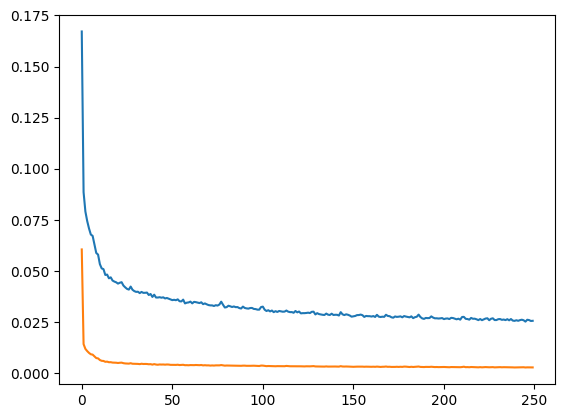

In [ ]:
loss = history.history["loss"]
mae = history.history["MAE"]

plt.plot(mae)
plt.plot(loss)

In [ ]:
import os
import pickle

path_save = f"../../models/{dataset}/{adj_type}/{service}/{type_data}/{pre_len}/lstm"
if not os.path.exists(path_save):
    os.makedirs(path_save)

with open(f"{path_save}/losses.pk", "wb") as f:
    pickle.dump((loss, mae), f)    
multivariate_lstm.save(f"{path_save}/best_model")

INFO:tensorflow:Assets written to: ../../models/microservices/good/no/duration/12/lstm/best_model/assets


INFO:tensorflow:Assets written to: ../../models/microservices/good/no/duration/12/lstm/best_model/assets


Получить предикты

#### microservices

default_data

In [49]:
import os

dataset = "microservices"
data_path = f"../../data/{dataset}"
adj_type = "bad"
service = "no"
type_data = "duration"
feat_path = f"{data_path}/{service}_fault_{type_data}.npy"
data = np.load(feat_path).transpose(2, 0, 1)[:, :, 0]

model_type = "lstm"
seq_len = 12
pre_len = 12

model_path = f"../../models/{dataset}/{adj_type}/{service}/{type_data}/{pre_len}/{model_type}/best_model"
save_path = f"../../result_predict/{dataset}/{adj_type}/{service}/{type_data}/{pre_len}/{model_type}"

if not os.path.exists(save_path):
    os.makedirs(save_path)

multivariate_lstm = tf.keras.models.load_model(f"{model_path}")
multivariate_lstm.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 200)               170400    
                                                                 
 dropout_1 (Dropout)         (None, 200)               0         
                                                                 
 dense_1 (Dense)             (None, 144)               28944     
                                                                 
Total params: 199,344
Trainable params: 199,344
Non-trainable params: 0
_________________________________________________________________


In [50]:
train_data, test_data = train_test_split(data=data)
means = data.min(axis=0)
stds = data.max(axis=0)

train_data_normalized = normalize_data(train_data, means, stds)
test_data_normalized = normalize_data(test_data, means, stds)

X_train, Y_train = xy_split(train_data_normalized, seq_len, pre_len)
X_test, Y_test = xy_split(test_data_normalized, seq_len, pre_len)

/home/dam/diplom/.venv37/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in true_divide


In [51]:
Y_pred_2d = multivariate_lstm.predict(X_train)
Y_pred = Y_pred_2d.reshape(Y_pred_2d.shape[0], sensor_count, pre_len)
Y_pred = denormalize_data(Y_pred, means.reshape([-1, 1]), stds.reshape([-1, 1]))
np.save(f"{save_path}/train.npy", Y_pred)

40/40 [==============================] - 2s 21ms/step


In [31]:
Y_pred_2d = multivariate_lstm.predict(X_test)
Y_pred = Y_pred_2d.reshape(Y_pred_2d.shape[0], sensor_count, pre_len)

10/10 [==============================] - 0s 16ms/step


In [32]:
Y_pred = denormalize_data(Y_pred, means.reshape([-1, 1]), stds.reshape([-1, 1]))
Y_test = denormalize_data(Y_test, means.reshape([-1, 1]), stds.reshape([-1, 1]))

In [33]:
np.save(f"{save_path}/test.npy", Y_pred)

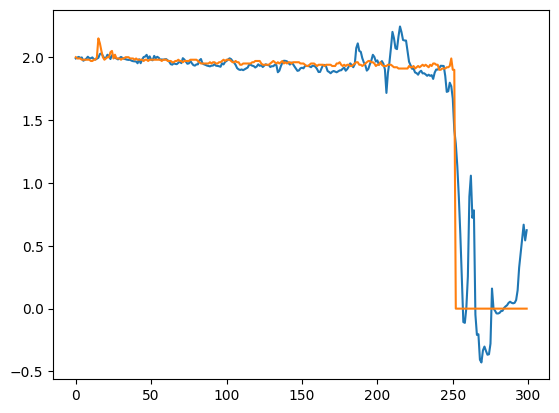

In [224]:
plt.plot(Y_pred[:, 1, 0])
plt.plot(Y_test[:, 1, 0])

fault data

In [225]:
for service in ("cart", "currency", "product"):
    feat_path = f"{data_path}/{service}_fault_{type_data}.npy"
    save_path = f"../../result_predict/{dataset}/{adj_type}/{service}/{type_data}/{pre_len}/{model_type}"
    if not os.path.exists(save_path):
        os.makedirs(save_path)

    data = np.load(feat_path).transpose(2, 0, 1)[:, :, 0]

    data_normalized = normalize_data(data, means, stds)
    X_test, Y_test = xy_split(data_normalized, seq_len, pre_len)
    Y_pred_2d = multivariate_lstm.predict(X_test)
    Y_pred = Y_pred_2d.reshape(Y_pred_2d.shape[0], sensor_count, pre_len)
    Y_pred = denormalize_data(Y_pred, means.reshape([-1, 1]), stds.reshape([-1, 1]))
    np.nan_to_num(Y_pred, 0)
    np.save(f"{save_path}/test.npy", Y_pred)

 6/12 [==============>...............] - ETA: 0s

/home/dam/diplom/.venv37/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in true_divide


 9/17 [==============>...............] - ETA: 0s

/home/dam/diplom/.venv37/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in true_divide


17/17 [==============================] - 0s 13ms/step


In [226]:
service = "product"

feat_path = f"{data_path}/{service}_fault_{type_data}.npy"
data = np.load(feat_path).transpose(2, 0, 1)[:, :, 0]

data_normalized = normalize_data(data, means, stds)
X_test, Y_test = xy_split(data_normalized, seq_len, pre_len)
Y_pred_2d = multivariate_lstm.predict(X_test)
Y_pred = Y_pred_2d.reshape(Y_pred_2d.shape[0], sensor_count, pre_len)
Y_pred = denormalize_data(Y_pred, means.reshape([-1, 1]), stds.reshape([-1, 1]))
Y_test = denormalize_data(Y_test, means.reshape([-1, 1]), stds.reshape([-1, 1]))

 5/17 [=======>......................] - ETA: 0s

/home/dam/diplom/.venv37/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in true_divide
/home/dam/diplom/.venv37/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in true_divide


17/17 [==============================] - 0s 13ms/step


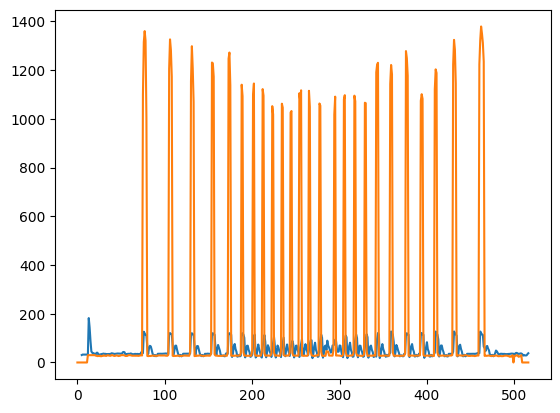

In [227]:
plt.plot(Y_pred[:, 2, 0])
plt.plot(Y_test[:, 2, 0])